## Experimental: my own work

Some example problems are (increasing complexity):
- FBPass for a single conv layer: Find loss gradient for both kernel and input.
- Add bias and an activation function (AF).
- Add a pooling layer, and a fully connected dense layer ( This will give full score! )

In [132]:

import numpy as np
import matplotlib.pyplot as plt

In [133]:
import keras
from keras.datasets import mnist
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

### Simplest case - binary classification
A single convolutional layer, then a a dense layer.

In [134]:
# Reduce to a binary classification problem
train_idx = np.where((y_train==0)|(y_train==1))[0]
test_idx = np.where((y_test==0)|(y_test==1))[0]

X_train = X_train[train_idx]
y_train = y_train[train_idx]
X_test = X_test[test_idx]
y_test = y_test[test_idx]

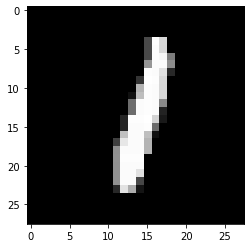

In [135]:
plt.imshow(X_test[100], cmap="gray")

In [136]:
def convolution(X, F, b=0, s=1):
    # Convolutional layer
    # note: no padding and depth=1 just to make calculations a bit simpler
    # Output feature size
    w_out = (X.shape[0] - F.shape[0])//s + 1
    h_out = (X.shape[1] - F.shape[1])//s + 1
    z = np.zeros((h_out, w_out))
    for j in range(0, w_out, s):
        for i in range(0, h_out, s):
            z[i,j] = X[i:i+F.shape[1], j:j+F.shape[0]].flatten().dot(F.flatten()) + b
    return z

def max_pool(X, k, s):
    h_out = (X.shape[0] - k)//s + 1
    w_out = (X.shape[1] - k)//s + 1
    z = np.zeros((h_out, w_out))
    idx = []
    for j in range(0, h_out):
        for i in range(0, w_out):
            block = X[j*k:j*k+k, i*k:i*k+k]
            z[j,i] = np.max(block)
            index = np.add(np.unravel_index(block.argmax(), block.shape), (j*k, i*k))
            idx.append(index) # Save indices of max values for backward pass!
    return z, idx
    
def ReLU(x):
    return abs(x) * (x > 0) # abs just makes -0.0 into 0.0 for easier reading
def d_ReLU(x): # differentiated!
    return 1 * (x > 0)
def sigmoid(x):
    y = np.exp(x)
    return y / (1 + y)
def d_sigmoid(x): # differentiated!
    y = sigmoid(x)
    return y * (1.0 - y)
def bce_loss(y, p):
    # Binary cross-entropy loss function
    return -(y * np.log10(p) + (1-y) * np.log10(1-p))
def d_bce_loss(y,p): # differentiated!
    # Derivative wrt. p
    return (1 - y) / (1 - p) - (y / p)

In [137]:
def simple_fit(X_train, y_train, lr=0.1):
    # Initialize randomly
    b1 = 1.0 # conv Bias
    F = np.array([[1,-1],[-1,1]]) # Kernel
    w4 = np.random.randn(169)
    b4 = 0 # neuron Bias
    lr = 0.1 # Leanring rate
     
    losses = np.zeros(len(X_train))
    for i, X in enumerate(X_train):
        X = X/255 # normalize
        ####################
        ### Forward pass ###
        ####################
        # Convolution
        z1 = convolution(X, F, b1, s=1) # Perform convolution
        a1 = ReLU(z1) # Apply AF
        # Maxpool and flatten
        a2, max_idx = max_pool(a1, k=2, s=2)
        a3 = a2.flatten()
        # Fully-connected layer
        z4 = w4.dot(a3) + b4
        a4 = sigmoid(z4)
        # Loss
        loss = bce_loss(y_train[i], a4)
        losses[i] = loss
        ####################
        ### Backward pass ##
        ####################
        # Fully connected layer:
        delta = d_bce_loss(y_train[i], a4) * d_sigmoid(z4)
        b4 = b4 - lr * delta # Update bias
        delta = delta * a3 # Gradient wrt. w4
        w4 = w4 - lr * delta # Update weights

        # NEXT, we unflatten the backpropagated derivative:
        delta = delta.reshape(a2.shape)
        # maxpooling layer
        d = np.zeros(a1.shape)
        for idx, grad in zip(max_idx, delta.flatten()):
            i, j = idx[0], idx[1]
            d[i,j] = grad
        delta = d
        # Backprop through delta
        delta = d_ReLU(z1) * delta
        # The conv bias
        grad_b1 = delta.sum() # dL/d(b1)
        # The conv kernel
        grad_F = convolution(X, delta)
        model = {"b1":b1, "F":F, "b4":b4, "w4":w4}
    return model, losses
        

def prediction(model, test_data):
    for i, X in enumerate(test_data):
        X = X/255 # normalize
        b1 = model["b1"]
        F = model["F"]
        b4 = model["b4"]
        w4 = model["w4"]
        predictions = np.zeros(len(test_data))
        ####################
        ### Forward pass ###
        ####################
        # Convolution
        z1 = convolution(X, F, b1, s=1) # Perform convolution
        a1 = ReLU(z1) # Apply AF
        # Maxpool and flatten
        a2, max_idx = max_pool(a1, k=2, s=2)
        a3 = a2.flatten()
        # Fully-connected layer
        z4 = w4.dot(a3) + b4
        a4 = sigmoid(z4)
        # Loss
        predictions[i] = a4
    return predictions

In [138]:
model, losses = simple_fit(X_train, y_train, lr=0.1)

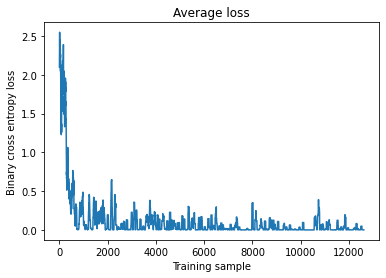

In [139]:
# Average loss over time
avg = np.convolve(losses, np.ones(50)/50, mode='valid')
# plotting the loss
plt.title("Average loss")
plt.xlabel("Training sample")
plt.ylabel("Binary cross entropy loss")
plt.plot(np.linspace(0, len(avg), len(avg)), avg);

In [140]:
preds = prediction(model, X_test)

In [141]:
print("Accuracy:", np.sum(np.abs(np.round(preds, 1) - y_test)) / len(y_test) * 100,"%")

Accuracy: 53.61702127659574 %


In [143]:
preds = prediction(model, X_train)
print("Accuracy:", np.sum(np.abs(np.round(preds, 1) - y_train)) / len(y_train) * 100,"%")

Accuracy: 53.225424397947094 %
